## 4. 自己エネルギーを計算してみよう

この章では、DMFT/IPTを用いて、自己エネルギーを計算してみる。また計算コストの削減のため[Sparse-IR](https://spm-lab.github.io/sparse-ir-tutorial/src/DMFT_IPT_py.html)を用いる。(詳しくは論文[arXiv:2206.11762](https://arxiv.org/abs/2206.11762)を読もう！)

まずDMFTとSparseIRの説明を簡単に行う。

DMFT(Dynamical Mean-Field Theory, 動的平均場理論)とは、空間揺らぎを無視しつつ動的な揺らぎをFullに取り込んで相互作用を計算する手法である。空間揺らぎを無視できる無限次元(空間次元)で厳密に正しい。界隈の感覚として、「３次元では十分良い結果を出し、２次元ではちょっと微妙(論文で使うと査読されたときに少し文句を言われる事がある)、１次元で使ってはいけない」という感じだと思う。空間揺らぎを部分的に取り込むように拡張されたDMFTも存在し(cDMFT(cluster DMFT)やrDMFT(real-space DMFT)、dual Fermion法など)、２次元だとこちらを使う事が推奨されたりする。

DMFTの手順としては、
1. latticeの波数のグリーン関数から(波数積分をして)localなグリーン関数を計算する。(calculate $G_0(r=0,iw)$)
2. それを用いて、そのサイトでの相互作用・自己エネルギーを計算する。(一番簡単な場合だと不純物問題に落ちているので厳密に計算可能)(Calculate $\Sigma(r=0, iw)$)
3. 自己エネルギー込みのlatticeの波数のグリーン関数から(波数積分をして)localなグリーン関数を計算し、その後onsiteの自己エネルギーを差っ引いてそのサイトだけ相互作用がない場合のグリーン関数を求める。(calculate $G_0(r=0,iw)　= (G_(r=0,iw)^{-1} + \Sigma(r=0, iw))^{-1}$)

3で今注目されているサイトのみから自己エネルギーをくり抜いていて、他のサイトには自己エネルギーが残っている状態でのオンサイトのグリーン関数を計算して、その状態での不純物状態を計算している。2・3を繰り返す事で、2の不純物問題を解く時のBathの状態を更新していき、最終的に動的な揺らぎをFullに取り込んだグリーン関数・自己エネルギーを計算する事が出来る。


IPTにおいては、不純物問題を解く時に、虚時間グリーン関数にして自己エネルギーを計算するのが早いわけだが、実周波数と虚時間の間を行き来する際に、$\exp[-\omega\tau]$がかかるので、極端な圧縮・拡大が存在し、そのままでは数値誤差がものすごく増大してしまう。

そこで出てくるのがIR basis(Intemediate Representation basis)である。実周波数と虚時間の間の変換はそれぞれをmeshだと思うと行列で表示できるので、これを特異値分解し、極端に誤差を増幅するものを取り除くことにする。この特異値の固有状態がIR basisである。また実周波数と虚時間の間の変換は毎回同じなので、一度この特異値分解をやっておいて、ライブラリとして置けば簡単に使えると言う有難ものである。

以下IR-basisを使うためのライブラリ「SparseIR」を用いて、DMFT/IPTを計算していく。


まずはパッケージを入れるところから

In [1]:
import Pkg
using Pkg
Pkg.add("SparseIR")

   Resolving package versions...
   Installed SIMD ───────────────── v3.7.1
   Installed GenericLinearAlgebra ─ v0.3.15
   Installed Bessels ────────────── v0.2.8
   Installed SparseIR ───────────── v1.1.4
   Installed MultiFloats ────────── v2.3.0
    Updating `~/.julia/environments/v1.11/Project.toml`
  [4fe2279e] + SparseIR v1.1.4
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [0e736298] + Bessels v0.2.8
  [14197337] + GenericLinearAlgebra v0.3.15
  [bdf0d083] + MultiFloats v2.3.0
  [fdea26ae] + SIMD v3.7.1
  [4fe2279e] + SparseIR v1.1.4
Precompiling project...
    567.3 ms  ✓ GenericLinearAlgebra
    806.1 ms  ✓ Bessels
   2968.9 ms  ✓ SIMD
    683.6 ms  ✓ MultiFloats
  16792.3 ms  ✓ SparseIR
  5 dependencies successfully precompiled in 21 seconds. 245 already precompiled.


ハミルトニアンを渡す関数、ブリルアンゾーンをベクトルで渡す関数などを定義する(２次元はDMFT微妙と言いつつ、三次元の計算は面倒なので、２次元のsuqare latticeでspinlessのフェルミオンを考えます)

In [ ]:
using LinearAlgebra
struct Parm
    t_i::Float64
    #Pr::Float64
    mu::Float64
    eta::Float64
    K_SIZE::Int
    dk2::Float64
end

function get_kk(K_SIZE::Int)
    kk::Vector{Vector{Float64}} = []
    dk = 2pi/(K_SIZE)
    for x in collect(-pi+dk:dk:pi)
        for y in collect(-pi+dk:dk:pi)
            k0 = [x, y]
            push!(kk,k0)
        end
    end
    return kk
end

function set_H(k::Vector{Float64},p::Parm)
    eps::Float64 = -2.0p.t_i*(cos(k[1]) + cos(k[2])) + p.mu
    #(p.Pr*cos(k'*a1) + cos(k'*a2) + cos(k'*a3)) + p.mu
    return eps
end

function Disp_HSL(p::Parm)
    E = zeros(Float64, 4*p.K_SIZE)

    for K0 in 1:p.K_SIZE
        KK = pi*K0/p.K_SIZE
        kk = [KK, 0.0]
        E[K0] = set_H(kk, p)
    end
    for K0 in 1:p.K_SIZE
        KK = pi*K0/p.K_SIZE
        kk = [pi-KK, KK]
        E[K0+p.K_SIZE] = set_H(kk, p)
    end
    for K0 in 1:p.K_SIZE
        KK = pi*K0/p.K_SIZE
        kk = [0.0, pi-KK]
        E[K0+2p.K_SIZE] = set_H(kk, p)
    end
    for K0 in 1:p.K_SIZE
        KK = pi*K0/p.K_SIZE
        kk = [KK, KK]
        E[K0+3p.K_SIZE] = set_H(kk, p)
    end
    p1 = plot(E, label="e",xlabel="HSL",xticks=([0, p.K_SIZE, 2p.K_SIZE, 3p.K_SIZE, 4p.K_SIZE],["Γ", "X", "X'", "Γ", "M"]),ylabel="E",title="Dispersion", width=3.0)
    savefig(p1,"./free_disp.png")

    return p1
end


function Spectral_HSL(p::Parm, w_mesh::Vector{Float64}, sigma_w::Vector{ComplexF64})
    E = zeros(Float64, 4*p.K_SIZE, length(sigma_w))

    for K0 in 1:p.K_SIZE
        KK = pi*K0/p.K_SIZE
        kk = [KK, 0.0]
        E[K0,:] = -imag.(1.0 ./( w_mesh .- set_H(kk, p) .- sigma_w))
    end
    for K0 in 1:p.K_SIZE
        KK = pi*K0/p.K_SIZE
        kk = [pi-KK, KK]
        E[K0+p.K_SIZE,:] = -imag.(1.0 ./( w_mesh .- set_H(kk, p) .- sigma_w))
    end
    for K0 in 1:p.K_SIZE
        KK = pi*K0/p.K_SIZE
        kk = [0.0, pi-KK]
        E[K0+2p.K_SIZE,:] = -imag.(1.0 ./( w_mesh .- set_H(kk, p) .- sigma_w))
    end
    for K0 in 1:p.K_SIZE
        KK = pi*K0/p.K_SIZE
        kk = [KK, KK]
        E[K0+3p.K_SIZE,:] = -imag.(1.0 ./( w_mesh .- set_H(kk, p) .- sigma_w))
    end
    q = 1:4p.K_SIZE
    p1 = plot(q, w_mesh, E,st=:heatmap, label="e",xlabel="HSL",xticks=([0, p.K_SIZE, 2p.K_SIZE, 3p.K_SIZE, 4p.K_SIZE],["Γ", "X", "X'", "Γ", "M"]),ylabel="E",title="Dispersion", width=3.0)
    savefig(p1,"./disp.png")

    return nothing
end

Spectral_HSL (generic function with 1 method)

In [2]:
px = Parm(0.5, -4.0, 0.01, 200, (1.0/200)^2)
kk = get_kk(px.K_SIZE)
println(px)

Parm(0.5, -4.0, 0.01, 200, 2.5e-5)


分散とかプロットしてみる(教育的な意味とデバッグも兼ねて)

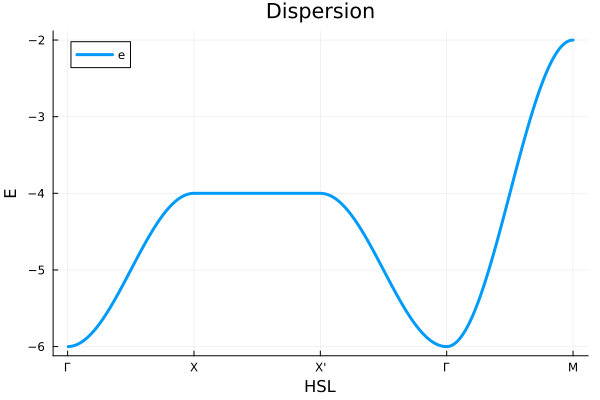

In [3]:
using  Plots
#Plots.scalefontsizes(1.4)
ps = Disp_HSL(px)
#ENV["GKSwstype"]="nul"
#Plots.scalefontsizes(1.4)

さてSparseIRをインポートする

In [4]:
using SparseIR
import SparseIR: valueim, value
import SparseIR: fit

IR表現と、松原振動数、虚時間、実周波数の表現を行き来するために用いるパラメーターやベクトル行列などを格納するstructを作っておく(UはParmに入れた方が良かったかも)

In [5]:
struct IR_params
    U::Float64 # Hubbard Interaction
    beta::Float64 #inverse temperature
    bw::Float64 #Band-width

    basis::FiniteTempBasis #this is the struct defined in SparseIR. This holds the information about Fermionic/Bosonic, and the matrix which can translate the Matsubara or imaginary time to IR-basis and the inverse.
    #{Fermionic, LogisticKernel, Float64, Float64}
    
    smpl_matsu::MatsubaraSampling64F #the sampling points of Matsubara frequency
    smpl_tau::TauSampling64 #the sampling points of imaginary time

    n_matsu::Int # the number of the sampling points of Matsubara frequency
    n_tau::Int # the number of the sampling points of imaginary time
    #n_ir::Int # the number of the sampling points of IR frequency

    smpl_wn::Vector{ComplexF64}#the sampling points of Matsubara frequency(type is different from smpl_matsu)
end

#IR_paramsをセットするための関数
function set_IR(U::Float64, beta::Float64, bw::Float64)
    #SparseIRの関数を使ってbasisを定義する。
    #FiniteTempBasis(粒子の種類, 逆温度, バンド幅, 許容する誤差(特異値分解の際に使用))
    basis = FiniteTempBasis(Fermionic(), beta, bw, 1e-8)

    #よく使うことになるので、basisから松原と虚時間のsampling pointsを取り出しておく
    smpl_matsu = MatsubaraSampling(basis)
    n_matsu = size(smpl_matsu.sampling_points)[1]

    smpl_tau = TauSampling(basis)
    n_tau = size(smpl_tau.sampling_points)[1]

    #smpl_matsuのままだとtypeがよく分からず後に不便を感じたのでVector{Complex}の型に直しておく
    smpl_wn = zeros(ComplexF64, n_matsu)
    for w in 1:n_matsu
        smpl_wn[w] = valueim(smpl_matsu.sampling_points[w], beta)
    end

    return U, beta, bw, basis, smpl_matsu, smpl_tau, n_matsu, n_tau, smpl_wn
end

set_IR (generic function with 1 method)

相互作用を計算するためのグリーン関数のstructも作っておく

In [6]:
#グリーン関数と自己エネルギーを格納するためのstruct
mutable struct Green_Sigma
    #注目しているサイトから相互作用をくり抜いた、IR/虚時間/松原　基底でのグリーン関数
    g0_ir::Vector{ComplexF64}
    g0_tau::Vector{ComplexF64}
    g0_matsu::Vector{ComplexF64}

    #相互作用を含んだ、IR/松原　基底でのグリーン関数
    #虚時間のグリーン関数は自己エネルギーを計算する時に飲み使うのでg0だけあれば良い
    g_ir::Vector{ComplexF64}
    g_matsu::Vector{ComplexF64}

    #IR/松原　基底での自己エネルギー
    sigma_ir::Vector{ComplexF64}
    sigma_tau::Vector{ComplexF64}
    sigma_matsu::Vector{ComplexF64}

    #IR基底でのsampling pointの数。set_IRの時点でこれを抽出するやり方が分からなかったのでここに格納。本当はIR_paramsの中にあるのが一番良い。
    n_ir::Int
end

#一旦zerosで型とサイズだけ確定させとく
function init_zero_g(ir::IR_params)
    
    g0_tau = zeros(ComplexF64, ir.n_tau)
    g0_matsu = zeros(ComplexF64, ir.n_matsu)
    g0_ir = fit(ir.smpl_matsu, g0_matsu, dim=1)

    n_ir = size(g0_ir)[1]

    g_ir = zeros(ComplexF64, n_ir)
    g_matsu = zeros(ComplexF64, ir.n_matsu)

    sigma_ir = zeros(ComplexF64, n_ir)
    sigma_tau = zeros(ComplexF64, ir.n_tau)
    sigma_matsu = zeros(ComplexF64, ir.n_matsu)

    return g0_ir, g0_tau, g0_matsu, g_ir, g_matsu, sigma_ir, sigma_tau, sigma_matsu, n_ir
end


function gk_m(p::Parm, k::Vector{Float64}, w::ComplexF64, g::Green_Sigma)
    e = set_H(k,p)
    gk = 1.0/(w - e - g.sig)
    return gk
end

#G0を計算する関数。iterationの１回目の時のみ自己エネルギーを含めずに計算するのでこのように書いている。(swはiterationのindex)
function get_G0mlocal(p::Parm, k_BZ::Vector{Vector{Float64}}, w::ComplexF64, sw::Int, sigma::ComplexF64)
    gw_l = 0.0
    gl = 0.0
    if(sw == 1)
        for i in 1:length(k_BZ)
            e = set_H(k_BZ[i],p) - p.mu
            #gk = 1.0/(w - e + p.eta*1.0im*sign(imag(w)))
            gk = 1.0/(w - e)
            gw_l += p.dk2 * gk
        end
    else
        for i in 1:length(k_BZ)
            e = set_H(k_BZ[i],p) - p.mu
            #gk = 1.0/(w - e -sigma + p.eta*1.0im*sign(imag(w)))
            gk = 1.0/(w - e -sigma)
            gl += p.dk2 * gk
        end
        gw_l = 1.0/(1.0/gl + sigma)
    end
    return gw_l, gl
end

get_G0mlocal (generic function with 1 method)

In [7]:
#自己エネルギーの計算のためのIRを経由しての松原から虚時間への変換
function MatsuToTau!(ir::IR_params, g::Green_Sigma)
    #fit(サンプリングポイント, サンプリングポイントでの値, dim=1)でIR基底に変換してくれる
    g.g0_ir = fit(ir.smpl_matsu, g.g0_matsu, dim=1)
    g.g_ir = fit(ir.smpl_matsu, g.g_matsu, dim=1)

    #evaluate(変換後の基底のサンプリングポイント, IRのサンプリングポイントでの値, dim=1)でIRから虚時間や松原に変換してくれる
    g.g0_tau = evaluate(ir.smpl_tau, g.g0_ir, dim=1)
end

#latticeでの計算のためのIRを経由しての虚時間から松原への変換
#ついでに前回のiterationから自己エネルギーがどれくらい変化しているのかをみる
function TauToMatsu!(ir::IR_params, g::Green_Sigma, γ::Float64)
    ir_new = fit(ir.smpl_tau, g.sigma_tau)
    
    #自己エネルギーの変化率を計算
    diff = sum(abs.(ir_new .- g.sigma_ir))/sum(abs.(g.sigma_ir))

    #更新率γで自己エネルギーを更新していく。初期の頃のiterationでの挙動を安定させるために設定
    g.sigma_ir = (1.0-γ) .* g.sigma_ir .+ γ .* ir_new

    g.sigma_matsu = evaluate(ir.smpl_matsu, g.sigma_ir, dim=1)

    return diff
end

function update_g!(p::Parm, k_BZ::Vector{Vector{Float64}},sw::Int, ir::IR_params, g::Green_Sigma, γ::Float64)
    #latticeでG0, Gを計算
    for w in 1:ir.n_matsu
        #g.g0_matsu[w], g.g_matsu[w] = get_G0mlocal(p, k_BZ, valueim(ir.smpl_matsu.sampling_points[w], ir.beta), sw, g.sigma_matsu[w])
        g.g0_matsu[w], g.g_matsu[w] = get_G0mlocal(p, k_BZ, ir.smpl_wn[w], sw, g.sigma_matsu[w])
    end
    #松原からIRを経由して虚時間へ
    MatsuToTau!(ir, g)
    #虚時間で自己エネルギーを計算
    g.sigma_tau = ir.U^2 .* (g.g0_tau).^2 .* g.g0_tau[end:-1:1]
    # .+ ir.U .* g.g0_tau
    
    #虚時間からIRを経由して松原へ。iterationでの変化率を計算
    diff = TauToMatsu!(ir, g, γ)
    return diff
end

update_g! (generic function with 1 method)

In [8]:
irx = IR_params(set_IR(8.0, 100.0, 8.0)...)

IR_params(8.0, 100.0, 8.0, FiniteTempBasis{Fermionic, LogisticKernel}(LogisticKernel(800.0), SparseIR.SVEResult{LogisticKernel}(SparseIR.PiecewiseLegendrePoly[SparseIR.PiecewiseLegendrePoly(16, -1.0, 1.0, [-1.0, -0.9996271898759757, -0.9991970683750346, -0.9987008253785223, -0.9981282965763918, -0.9974677553874861, -0.9967056729452549, -0.9958264412682684, -0.9948120539999259, -0.9936417382620432  …  0.9936417382620432, 0.9948120539999259, 0.9958264412682684, 0.9967056729452549, 0.9974677553874861, 0.9981282965763918, 0.9987008253785223, 0.9991970683750346, 0.9996271898759757, 1.0], [0.00037281012402434754, 0.0004301215009410164, 0.0004962429965122972, 0.0005725288021305452, 0.0006605411889056834, 0.0007620824422311934, 0.0008792316769865582, 0.0010143872683424648, 0.0011703157378827322, 0.0013502080512508563  …  0.0013502080512508563, 0.0011703157378827322, 0.0010143872683424648, 0.0008792316769865582, 0.0007620824422311934, 0.0006605411889056834, 0.0005725288021305452, 0.000496242996

In [9]:
gx = Green_Sigma(init_zero_g(irx)...)
for it in 1:1000
    L1 = update_g!(px,kk,it,irx,gx, 0.2)
    if(L1<1e-8)
        println("self-energy converges at itr:", it)
        break
    end
end

self-energy converges at itr:157


In [21]:
import JuMP
using Ipopt

In [24]:
w_num = 1001
w_mesh = collect(-irx.bw:2irx.bw/(w_num-1):irx.bw)
tr_w = transpose(irx.basis.v(w_mesh))

function F_rho0(ir::IR_params, g::Green_Sigma, rho_ls, λ)
    #正しいrho_lsならばこれがゼロになるはず
    vec = g.g0_ir - ir.basis.s .* rho_ls

    #vecのL2ノルムとrho_lsのL1ノルムをコスト関数とする。第二項はノイズを除去する役割
    return f = 0.5*real(vec'*vec) + λ*sum(abs.(rho_ls))
end

function F_rho(ir::IR_params, g::Green_Sigma, rho_ls, λ)
    vec = g.g_ir - ir.basis.s .* rho_ls
    return f = 0.5*real(vec'*vec) + λ*sum(abs.(rho_ls))
end

F_rho (generic function with 1 method)

In [34]:
function fit_rho0w(ir::IR_params, g::Green_Sigma, l_num::Int)
    sn = range(-12.0, 0.0, length=l_num)

    #F_rho0でのL1ノルムをどれくらい考慮するかにはλによって変わる。λが大きすぎると、極端に要素が減らされる(勝手にノイズと見做されてしまう)し、小さすぎるとノイズを取り込みすぎる。
    #そのためちょうど良いλを探すための計算をここから行う
    lam_test = 10 .^ (sn)

    #それぞれのλでのFittingされたrho_l
    #s_rho_l = rand(Float64, l_num, ir.n_ir)
    s_rho_l = rand(Float64, l_num, ir.n_matsu)

    #それぞれのλでのF_rhoの最小値(各batchで計算し最小値を更新・保持していくため)
    s_F_rho = zeros(Float64, l_num)
    status = zeros(Int, l_num)

    for ll in 1:l_num
        lam = lam_test[ll]
        model = Model(Ipopt.Optimizer)
        @variable(model, x[1:irx.n_matsu])

        @objective(model, Min, F_rho0(irx, gx, x, lam))

        @constraint(model, constraint1, real.(-tr_w * x) .>= 0.0)

        optimize!(model)
        solution_status = termination_status(model)
        println("解の状態: ", solution_status)
        s_rho_l[ll,:] = JuMP.value.(x)
        s_F_rho[ll] = objective_value(model)

        if solution_status == MOI.OPTIMAL
            status[ll] = 1
        else
            println("最適解が見つかりませんでした。")
        end
    end
    b = (log(s_F_rho[end])-log(s_F_rho[1]))/(log(lam_test[end])-log(lam_test[1]))
    a = s_F_rho[1]*lam_test[1]^(-b)
    #最終的な評価関数。これを使って最適なλを決める
    ev = a .* lam_test .^ b ./ s_F_rho

    return lam_test, ev, s_rho_l
end

function fit_rhow(ir::IR_params, g::Green_Sigma, l_num::Int)
    sn = range(-12.0, 0.0, length=l_num)

    #F_rho0でのL1ノルムをどれくらい考慮するかにはλによって変わる。λが大きすぎると、極端に要素が減らされる(勝手にノイズと見做されてしまう)し、小さすぎるとノイズを取り込みすぎる。
    #そのためちょうど良いλを探すための計算をここから行う
    lam_test = 10 .^ (sn)

    #それぞれのλでのFittingされたrho_l
    #s_rho_l = rand(Float64, l_num, ir.n_ir)
    s_rho_l = rand(Float64, l_num, ir.n_matsu)

    #それぞれのλでのF_rhoの最小値(各batchで計算し最小値を更新・保持していくため)
    s_F_rho = zeros(Float64, l_num)
    status = zeros(Int, l_num)

    for ll in 1:l_num
        lam = lam_test[ll]
        model = Model(Ipopt.Optimizer)
        @variable(model, x[1:irx.n_matsu])

        @objective(model, Min, F_rho(irx, gx, x, lam))

        @constraint(model, constraint1, real.(-tr_w * x) .>= 0.0)

        optimize!(model)
        solution_status = termination_status(model)
        println("解の状態: ", solution_status)
        s_rho_l[ll,:] = JuMP.value.(x)
        s_F_rho[ll] = objective_value(model)

        if solution_status == MOI.OPTIMAL
            status[ll] = 1
        else
            println("最適解が見つかりませんでした。")
        end
    end
    b = (log(s_F_rho[end])-log(s_F_rho[1]))/(log(lam_test[end])-log(lam_test[1]))
    a = s_F_rho[1]*lam_test[1]^(-b)
    #最終的な評価関数。これを使って最適なλを決める
    ev = a .* lam_test .^ b ./ s_F_rho

    return lam_test, ev, s_rho_l
end

fit_rhow (generic function with 1 method)

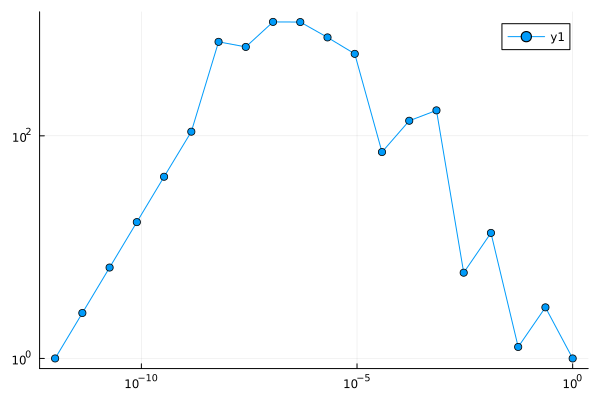

In [35]:
lamda_num = 20
lam, ev, rho_l = fit_rhow(irx, gx, lamda_num)
plot(lam, ev, xaxis=:log, yaxis=:log, marker=:circle)

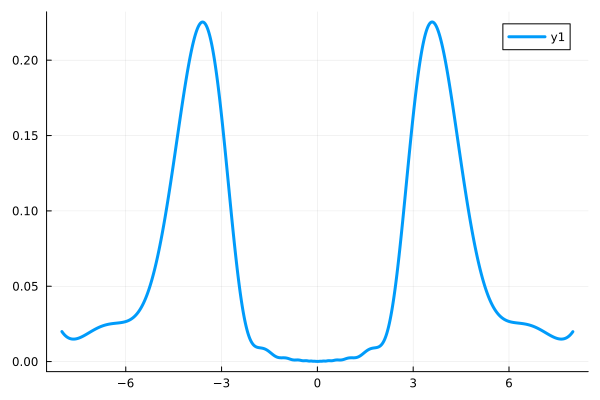

In [36]:
@show it = findmax(ev)[2]
rho_omega = -transpose(irx.basis.v(w_mesh)) * rho_l[it,:]
plot(w_mesh, real.(rho_omega), linewidth=3.0)

In [23]:
lam_test = 1e-3
model = Model(Ipopt.Optimizer)
@variable(model, x[1:irx.n_matsu])

@objective(model, Min, F_rho(irx, gx, x, lam_test))

@constraint(model, constraint1, real.(tr_w * x) .>= 0.0)

optimize!(model)
solution_status = termination_status(model)
println("解の状態: ", solution_status)
println(JuMP.value.(x))

if solution_status == MOI.OPTIMAL
    optimal_x = JuMP.value.(x)
    optimal_obj = objective_value(model)

    println("最適解:")
    println(" x = ", optimal_x)
    println("最適な目的関数値 z = ", optimal_obj)
else
    println("最適解が見つかりませんでした。")
end


This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    42030
Number of nonzeros in Lagrangian Hessian.............:       42

Total number of variables............................:       42
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1001
        inequality constraints with only lower bounds:     1001
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2377555e-02 0.00e+00 2.54e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

最後にIR基底でのスペクトル関数をFittingをして導出し、実周波数のスペクトル関数を出す。なるべくノイズを減らすためL1正則化して計算。Frhoの中身などは[arXiv:1702.03056(2017)](https://arxiv.org/pdf/1702.03056.pdf)を参照。
論文中で紹介されているアルゴリズムがあるのだが、せっかくなので自動微分を使って解く。(機械学習の手法を使う時にも同じようなコードで書けますし、ある意味教育的かなと)

真面目なアルゴリズムで解く場合は[arXiv:1702.03056(2017)](https://arxiv.org/pdf/1702.03056.pdf)を参照。

juliaで機械学習を使う場合は、Fluxというライブラリを用いるのでこれを使う。
勾配法で解を探すことになるため、local minimunにトラップされてしまう事がしばしばある。よって「幾つかの初期状態(batch)を用意し、そこから勾配法で掘り進んでいき、一番下まで掘り進めたものを解として採用する」という戦略をとる。

In [11]:
import Pkg
using Pkg
Pkg.add("Flux")

   Resolving package versions...
   Installed ContextVariablesX ──── v0.1.3
   Installed MLCore ─────────────── v1.0.0
   Installed ScopedValues ───────── v1.3.0
   Installed ShowCases ──────────── v0.1.0
   Installed Optimisers ─────────── v0.4.6
   Installed MLUtils ────────────── v0.4.8
   Installed PrettyPrint ────────── v0.2.0
   Installed NameResolution ─────── v0.1.5
   Installed MLDataDevices ──────── v1.9.1
   Installed FLoopsBase ─────────── v0.1.1
   Installed FLoops ─────────────── v0.2.2
   Installed KernelAbstractions ─── v0.9.34
   Installed HashArrayMappedTries ─ v0.2.0
   Installed Flux ───────────────── v0.16.3
   Installed EnzymeCore ─────────── v0.8.8
   Installed UnsafeAtomics ──────── v0.3.0
   Installed OneHotArrays ───────── v0.2.7
   Installed MLStyle ────────────── v0.4.17
   Installed ProgressLogging ────── v0.1.4
   Installed JuliaVariables ─────── v0.2.4
   Installed Atomix ─────────────── v1.1.1
   Installed NNlib ──────────────── v0.9.30
    Updating `~/.

In [10]:
using Flux

#G0の方のスペクトル関数をIR基底で求めるためのコスト関数。これを最小にするようにrho_lsを導く
function F_rho0(ir::IR_params, g::Green_Sigma, rho_ls, λ)
    #正しいrho_lsならばこれがゼロになるはず
    vec = g.g0_ir - ir.basis.s .* rho_ls

    #vecのL2ノルムとrho_lsのL1ノルムをコスト関数とする。第二項はノイズを除去する役割
    return f = 0.5*real(vec'*vec) + λ*sum(abs.(rho_ls))
end

function fit_rho0w(ir::IR_params, g::Green_Sigma, l_num::Int, batch_num::Int, w_mesh::Vector{Float64})
    sn = range(-12.0, 0.0, length=l_num)

    #F_rho0でのL1ノルムをどれくらい考慮するかにはλによって変わる。λが大きすぎると、極端に要素が減らされる(勝手にノイズと見做されてしまう)し、小さすぎるとノイズを取り込みすぎる。
    #そのためちょうど良いλを探すための計算をここから行う
    lam_test = 10 .^ (sn)

    #機械学習分野における最適化関数(得られた勾配に対してどのようにパラメータを更新するかの関数)。大体ADAMが最強っす。(時間はかかるがSGDの方が良い結果を出す場合もあるらしい)
    

    #それぞれのλでのFittingされたrho_l
    #s_rho_l = rand(Float64, l_num, ir.n_ir)
    s_rho_l = rand(Float64, l_num, ir.n_matsu)

    #それぞれのλでのF_rhoの最小値(各batchで計算し最小値を更新・保持していくため)
    s_F_rho = 1000.0 * ones(Float64, l_num)

    for ll in 1:l_num
        lam = lam_test[ll]
        for b in 1:batch_num
            opt = ADAM()
            #rho_ll = rand(Float64, ir.n_ir)
            rho_ll = rand(Float64, ir.n_matsu)
            setup = Flux.Optimisers.setup(opt, rho_ll)
            F_old = 1000.0
            F_new = 1000.0
            #勾配法を使って段々とF_rhoを下げるようにrho_llを更新していく
            for i in 1:10000
                #勾配を計算
                grads = Flux.gradient(x -> F_rho0(ir, g, x, lam), rho_ll)[1]
                #rho_llを更新
                Flux.Optimise.update!(setup, rho_ll, grads)
                F_old = F_new
                F_new = F_rho0(ir, g, rho_ll, lam)
                #更新率を計算し、十分小さくなればiterationを止める
                if(abs(F_old-F_new)/abs(F_old)<1e-6)
                    break
                end
            end
            #各batchで計算したF_rho(F_new)がs_F_rhoが保持している値よりも小さければ値を更新
            if(s_F_rho[ll] > F_new)
                s_rho_l[ll,:] = rho_ll
                s_F_rho[ll] = F_new
            end
        end
    end
    b = (log(s_F_rho[end])-log(s_F_rho[1]))/(log(lam_test[end])-log(lam_test[1]))
    a = s_F_rho[1]*lam_test[1]^(-b)
    #最終的な評価関数。これを使って最適なλを決める
    ev = a .* lam_test .^ b ./ s_F_rho

    return lam_test, ev, s_rho_l

    #p1 = plot(lam_test, ev, xaxis=:log, yaxis=:log, marker=:circle)
    #savefig(p1,"./lambda_opt_G0.png")

    #it = findmax(ev)[2]
    #println(it)
    #rho_omega = -transpose(ir.basis.v(w_mesh)) * s_rho_l[it,:]
    #return rho_omega
end

function F_rho(ir::IR_params, g::Green_Sigma, rho_ls, λ)
    vec = g.g_ir - ir.basis.s .* rho_ls
    return f = 0.5*real(vec'*vec) + λ*sum(abs.(rho_ls))
end

function fit_rhow(ir::IR_params, g::Green_Sigma, l_num::Int, batch_num::Int, w_mesh::Vector{Float64})
    sn = range(-10.0, 0.0, length=l_num)
    lam_test = 10 .^ (sn)
    s_rho_l = rand(Float64, l_num, ir.n_matsu)
    s_F_rho = 1000.0 * ones(Float64, l_num)

    for ll in 1:l_num
        lam = lam_test[ll]
        for b in 1:batch_num
            opt = ADAM()
            rho_ll = rand(Float64, ir.n_matsu)
            setup = Flux.Optimisers.setup(opt, rho_ll)
            
            F_old = 1000.0
            # * ones(Float64, ir.n_matsu-1)
            F_new = 1000.0
            # * ones(Float64, ir.n_matsu-1)
            for i in 1:10000
                grads = Flux.gradient(x -> F_rho(ir, g, x, lam), rho_ll)[1]
                #rho_llを更新
                Flux.Optimise.update!(setup, rho_ll, grads)
                F_old = F_new
                #F_new = rho_ll
                F_new = F_rho(ir, g, rho_ll, lam)
                #if(sum(abs.(F_old .- F_new))<1e-12)
                if(abs(F_old-F_new)/abs(F_old)<1e-7)
                    break
                end
            end
            if(s_F_rho[ll] > F_new)
                s_rho_l[ll,:] = rho_ll
                s_F_rho[ll] = F_new
            end
        end
    end
    b = (log(s_F_rho[end])-log(s_F_rho[1]))/(log(lam_test[end])-log(lam_test[1]))
    a = s_F_rho[1]*lam_test[1]^(-b)
    ev = a .* lam_test .^ b ./ s_F_rho

    return lam_test, ev, s_rho_l

    #p1 = plot(lam_test, ev, xaxis=:log, yaxis=:log, marker=:circle)
    #savefig(p1,"./lambda_opt_G0.png")

    #it = findmax(ev)[2]
    #println(it)
    #rho_omega = -transpose(ir.basis.v(w_mesh)) * s_rho_l[it,:]
    #return rho_omega
end


fit_rhow (generic function with 1 method)

ちなみに機械学習に興味がある人向けに少しRemark.
今回はIR基底でのスペクトル関数(rho_ll)をパラメータとして学習を行ったが、代わりに、
```
model = Chain(Dense(in_size, n_dense, tanh), Dense(n_dense, n_dense, tanh), Dense(n_dense, out_size))
```
のように中間２層(in_size => n_dense => n_dense => out_size)のニューラルネットを組み、
```
Flux.params(rho_ll) => Flux.params(model)
```
として、損失関数を書き換えれば、そのまま機械学習のコードになります。
modelは length=in_sizeのベクトルをインプットxとすれば、 y = model(x)でout_sizeの出力をしてくれます。

興味があればやってみましょう。

In [25]:
lamda_num = 20
batch_num = 150
w_num = 1001
w_mesh = collect(-irx.bw:2irx.bw/(w_num-1):irx.bw)
tr_w = transpose(irx.basis.v(w_mesh))
it_max = 15000
#rho, rho0 = fit_rhow(irx, gx, lamda_num, batch_num, tr_w, it_max)

15000

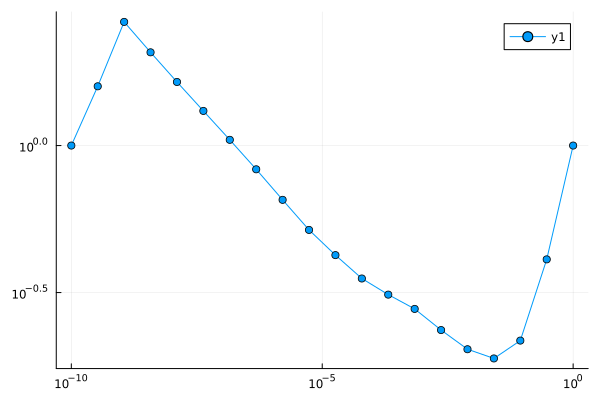

In [26]:
lam, ev, rho_l = fit_rhow(irx, gx, lamda_num, batch_num, w_mesh)
plot(lam, ev, xaxis=:log, yaxis=:log, marker=:circle)

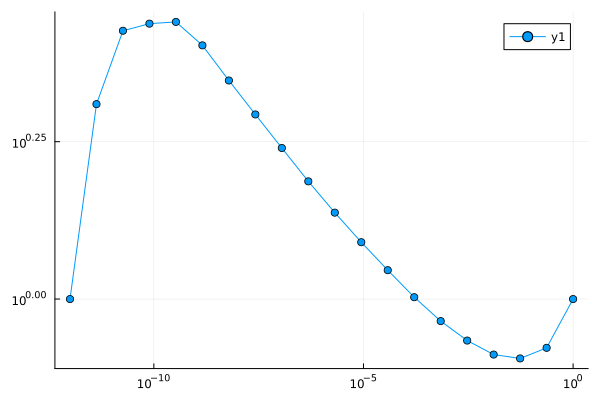

In [14]:
lam0, ev0, rho_l0 = fit_rho0w(irx, gx, lamda_num, batch_num, w_mesh)
plot(lam0, ev0, xaxis=:log, yaxis=:log, marker=:circle)

In [27]:
@show it0 = findmax(ev0)[2]
@show it = findmax(ev)[2]

it0 = (findmax(ev0))[2] = 5
it = (findmax(ev))[2] = 3


3

PlotしてみるとMott絶縁体っぽいスペクトルになっている。
ただFittingの誤差から負符号の部分が生じてしまっているのでこれを整形したい。
本当は、Fittingする時に、一度実周波数に戻して負符号の部分があればそれをコスト関数に組み込むようにすれば避けられるはずだが、計算時間がかかるので、ここではある種人為的にカットする。

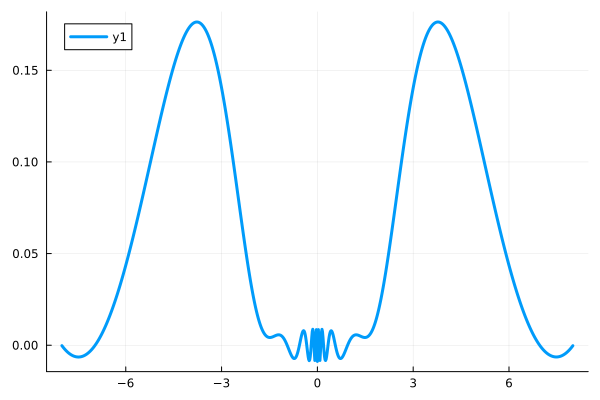

In [28]:
rho_omega = -transpose(irx.basis.v(w_mesh)) * rho_l[it,:]
plot(w_mesh, real.(rho_omega), linewidth=3.0)

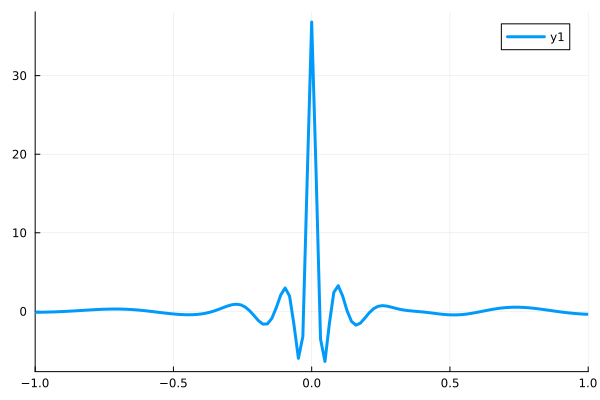

In [17]:
rho0_omega = -transpose(irx.basis.v(w_mesh)) * rho_l0[it0,:]
plot(w_mesh, real.(rho0_omega), linewidth=3.0, xrange=(-1.0,1.0))

In [18]:
#負符号の部分とそれに付随する振動部分を0に変える関数
#ピークが負符号に挟まれていて、かつピークの高さが高くない(cutoff以下)ならば0.0005に変える

function reshape(rho::Vector{Float64}, cutoff::Float64)
    v_it::Vector{Int} = []
    rho_rep = copy(rho)
    sw = true
    for w in 1:length(rho_rep)
        if(rho[w]>=cutoff && sw)
            empty!(v_it)
            sw = false
        elseif(rho[w]<0)
            if(sw)
                for it in v_it
                    rho_rep[it] = 0.0005                
                end
                empty!(v_it)
            else
                sw = true
            end
            rho_rep[w] = 0.0005
        elseif(rho[w]<cutoff && rho[w]>=0.0)
            if(sw)
                push!(v_it,w)
            end
        end
    end
    return rho_rep
end


#Kramers-Kronigを使ってGRを出す
function KK_GR(w::Vector{Float64}, rho::Vector{Float64})
    GR_ = zeros(ComplexF64, length(w))
    dw = w[2]-w[1]
    for w_re in 1:length(w)
        re::Float64 = 0.0
        for w_im in 1:length(w)
            if(w_im != w_re)
                re += dw * rho[w_im] / (w[w_re] - w[w_im])
            end 
        end
        GR_[w_re] = re - 1.0im * rho[w_re] * pi
    end
    return GR_
end

f(beta::Float64, w::Float64) = 1.0/(1.0+exp(beta*w))

#Half-fillingを課しているので、スペクトル関数を整形した結果half-fillingからずれないようにrenormalize
function renorm_rho(beta::Float64, w::Vector{Float64}, rho::Vector{Float64})
    n = 0.0
    dw = w[2]-w[1]
    for i in 1:length(w)
        n += dw * rho[i] * f(beta, w[i])
    end
    rho1 = (0.5/n) * rho
    return rho1
end

renorm_rho (generic function with 1 method)

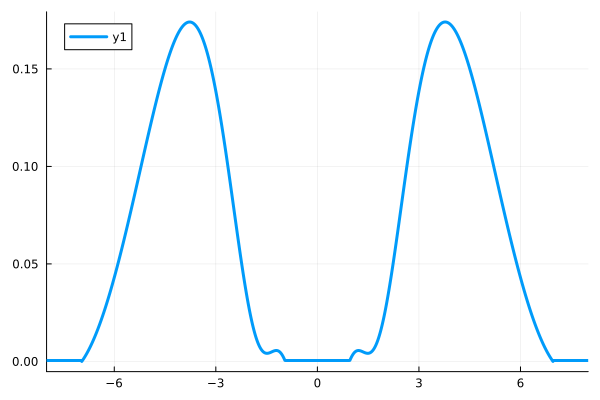

In [29]:
rint_res = reshape(rho_omega, 0.1)
#println("x")
r0_res = reshape(rho0_omega, 0.1)

rint_resr = renorm_rho(irx.beta, w_mesh, rint_res)
r0_resr = renorm_rho(irx.beta, w_mesh, r0_res)

plot(w_mesh, rint_resr, linewidth=3.0, xrange=(-8.0,8.0))

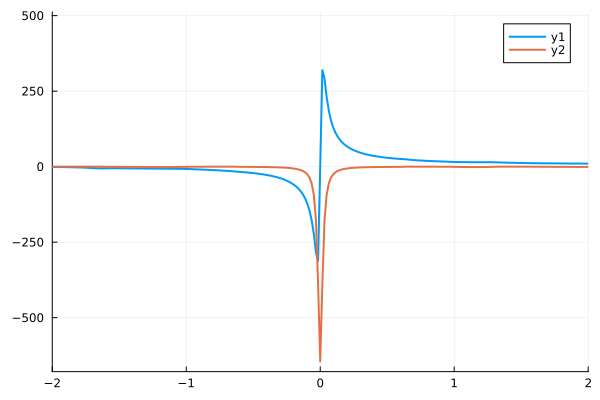

In [30]:
GR_int = KK_GR(w_mesh, rint_resr)
GR_0 = KK_GR(w_mesh, r0_resr)

sigma_w = zeros(ComplexF64, w_num)
for ww in 1:w_num
    sigma_w[ww] = 1.0/GR_0[ww] - 1.0/GR_int[ww] - px.mu
    if(imag(sigma_w[ww])>0)
        sigma_w[ww] = real(sigma_w[ww]) - 0.0001im
    end
end

plot(w_mesh, real.(sigma_w), linewidth=2.0, xrange=(-2.0,2.0))
plot!(w_mesh, imag.(sigma_w), linewidth=2.0)

さて実周波数の自己エネルギーが得られたので、これを使ってMott絶縁体の光学伝導度を計算してみよう。

In [21]:
mutable struct Green_opt
    GR::ComplexF64
    GA::ComplexF64
    GRmA::ComplexF64

    GRp::ComplexF64
    GAm::ComplexF64
end

mutable struct HandV
    e::Float64
    vx::Float64
    vy::Float64
end


In [31]:

function G_opt(id_w::Int, id_Win::Int, w_mesh, e::Float64, SE::Vector{ComplexF64}, p::Parm)
    GR::ComplexF64 = 1.0/(w_mesh[id_w]-e-SE[id_w] + 1.0im*p.eta)
    GA = GR'
    GRmA = GR - GA
    GRp::ComplexF64 = 0.0
    GAm::ComplexF64 = 0.0

    if(id_w>id_Win)
        GAm = (1.0/(w_mesh[id_w-id_Win]-e-SE[id_w-id_Win] + 1.0im*p.eta))'
    end
    if(id_w+id_Win <=w_num)
        GRp = 1.0/(w_mesh[id_w+id_Win]-e-SE[id_w+id_Win] + 1.0im*p.eta)
    end

    return GR, GA, GRmA, GRp, GAm
end

function set_HandV(p::Parm, k::Vector{Float64})
    e = set_H(k,p)
    vx = 2.0p.t_i*sin(k[1])
    vy = 2.0p.t_i*sin(k[2])
    return e, vx, vy
end

set_HandV (generic function with 1 method)

光学伝導度のΩ(inputの周波数)を調べてみる

In [32]:
dw = w_mesh[2]-w_mesh[1]
ll = 21
W1 = range(2.0,12.0, length=ll)
XX_opt = zeros(Float64, ll)
for i in 1:ll
    id_W1 = Int(floor(W1[i]/dw+0.1))
    for k1 in kk
        HV = HandV(set_HandV(px,k1)...)
        for id_w in 1:w_num
            GG = Green_opt(G_opt(id_w, id_W1, w_mesh, HV.e, sigma_w, px)...)
            XX_opt[i] += px.dk2 * dw * real(HV.vx * GG.GRp * HV.vx * GG.GRmA + HV.vx * GG.GRmA * HV.vx * GG.GAm)*f(irx.beta,w_mesh[id_w])/(2pi*W1[i])             
        end
    end
end


MottギャップのΩ=8くらいのところでピークが立つ。
今回考えている系は、元々はsingle-bandな系なので(相互作用が無ければ)光学伝導度は0なはずだが、自己エネルギーによるnon-Markov効果(自己エネルギーによってグリーン関数にpoleが増える効果)によって初めて光学伝導度が有限となる。

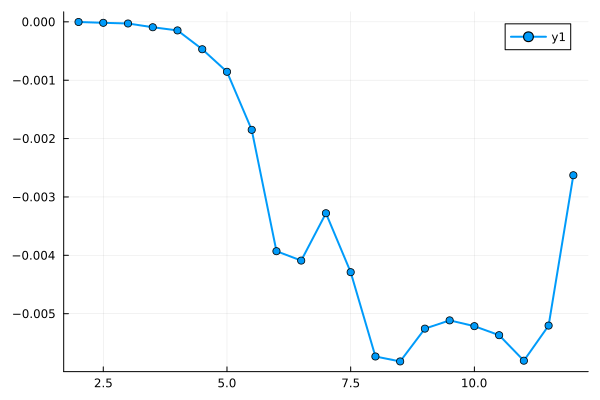

In [33]:
plot(W1, XX_opt, width=2.0, marker=:circle)